### **Install Requirements**

In [ ]:
pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow_hub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd  #For better data visualization we'll use Pandas library


In [ ]:
pd.set_option("display.precision", 8) # Increase precision of presented data for better side-by-side comparison



### Prepare dataset


In [ ]:
#Create data generator for training and validation

data_root='/content/drive/MyDrive/Train'
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/MyDrive/Train
Found 56 images belonging to 26 classes.
Found 224 images belonging to 26 classes.


In [ ]:
testpath='/content/drive/MyDrive/Testi'
testing=str(testpath)
print(datagen_kwargs)

{'rescale': 0.00392156862745098, 'validation_split': 0.2}


In [ ]:
#Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 26)


### Training


In [ ]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 26)                33306     
                                                                 
Total params: 2,291,290
Trainable params: 33,306
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Lets Train Our model!

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
7/7 [==============================] - 50s 5s/step - loss: 3.5563 - acc: 0.0848 - val_loss: 2.5957 - val_acc: 0.3214
Epoch 2/10
7/7 [==============================] - 1s 104ms/step - loss: 2.5613 - acc: 0.3304 - val_loss: 1.8942 - val_acc: 0.6429
Epoch 3/10
7/7 [==============================] - 1s 103ms/step - loss: 1.9966 - acc: 0.5000 - val_loss: 1.3656 - val_acc: 0.9286
Epoch 4/10
7/7 [==============================] - 1s 102ms/step - loss: 1.5221 - acc: 0.6518 - val_loss: 0.9756 - val_acc: 0.9643
Epoch 5/10
7/7 [==============================] - 1s 102ms/step - loss: 1.0984 - acc: 0.7857 - val_loss: 0.7094 - val_acc: 0.9643
Epoch 6/10
7/7 [==============================] - 1s 106ms/step - loss: 0.8636 - acc: 0.8884 - val_loss: 0.5195 - val_acc: 0.9643
Epoch 7/10
7/7 [==============================] - 1s 101ms/step - loss: 0.6349 - acc: 0.9286 - val_loss: 0.3946 - val_acc: 0.9643
Epoch 8/10
7/7 [==============================] - 1s 105ms/step - loss: 0.5131 - acc: 0.9420

In [ ]:
#Measure accuracy and loss after training


final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 0s 55ms/step - loss: 0.2071 - acc: 0.9643
Final loss: 0.21
Final accuracy: 96.43%


### Exporting Model


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


In [ ]:
import keras
import keras.utils
from keras import utils as np_utils

### Load TensorFlow SavedModel


In [39]:
# Load SavedModel

path = 'path.h5'
model.save(path)

In [40]:
model = tf.keras.models.load_model((path),custom_objects={'KerasLayer':hub.KerasLayer})


### Check predictions on loaded model


In [41]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (24, 224, 224, 3)


In [42]:
#Convert prediction results to Pandas dataframe, for better visualization

tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for elements")
tf_pred_dataframe.head()

Prediction results for elements


,0,1,10,11,12,13,14,15,16,17,...,23,24,25,3,4,5,6,7,8,9
0,0.00434242,0.00795514,0.00152624,0.00070781,0.00192251,0.00109804,0.00329398,0.00022478,0.00103681,0.00168552,...,0.00171479,0.00009786,0.00085087,0.00017715,0.00039484,0.00197743,0.00108741,0.00033113,0.00156669,0.00247502
1,0.00762020,0.01034558,0.00192698,0.00040160,0.00332195,0.00718180,0.02367570,0.00340785,0.00388510,0.00890551,...,0.01187671,0.00684909,0.02332203,0.00186704,0.00316614,0.01192197,0.00265706,0.00103090,0.00331442,0.00234136
2,0.01725584,0.03370484,0.00063754,0.00031698,0.00706703,0.04606598,0.00352304,0.02074687,0.01192246,0.00484195,...,0.01708066,0.01761399,0.02938764,0.00066062,0.00390104,0.00729873,0.00600883,0.00019860,0.00194386,0.00226214
3,0.00206911,0.00865612,0.00136926,0.00112053,0.00518582,0.01066552,0.00477747,0.00562113,0.00690681,0.88619816,...,0.00036484,0.00107704,0.01026847,0.00081303,0.00283001,0.00215615,0.00188858,0.00112561,0.01042958,0.01370101
4,0.00281992,0.00670799,0.00033565,0.00014558,0.00024287,0.00192266,0.00410045,0.00029428,0.00015751,0.00195244,...,0.01000387,0.00051912,0.01196415,0.00034039,0.92659396,0.00054473,0.00023071,0.00011809,0.00041613,0.00064831


In [43]:
classes = { 0:'Airbag_hover',
            1:'Airbag_hover', 
            2:'Brights_hover', 
            3:'checkBattery_hover', 
            4:'checkBrakes_hover', 
            5:'checkEngine_hover', 
            6:'checkOil_hover', 
            7:'doorOpen_hover', 
            8:'elephantTooting_hover', 
            9:'engineFlood_hover', 
            10:'engineMaintenance_hover', 
            11:'engineOil_hover',
            12:'Exhaust_hover', 
            13:'Gear_temp_hover', 
            14:'Hazard_hover', 
            15:'Lights_hover', 
            16:'Maintenance_hover', 
            17:'overdriveOff_hover', 
            18:'Overheat_hover', 
            19:'Rpm_hover', 
            20:'Skid_hover', 
            21:'tirePressure_hover', 
            22:'warning_hover', 
            23:'wheelLock_hover', 
            24:'wipersOut_hover', 
            25:'Wires_hover'}

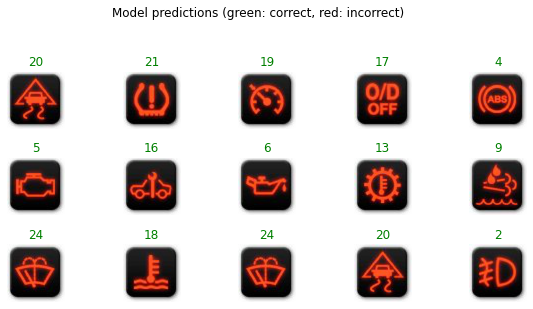

In [44]:
#Print images batch and labels predictions

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(15):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

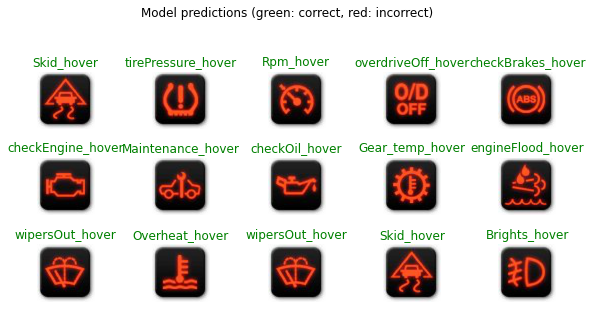

In [45]:
#Print images batch and labels predictions
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(15):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  for i in classes:
      a=int(predicted_labels[n].title())
      if a==i:
        name=classes[i]
  plt.title(name, color=color) 
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


20
Skid_hover


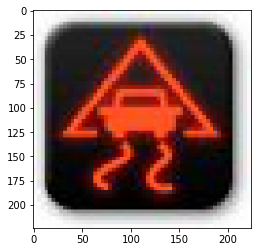

In [ ]:
test=val_image_batch[5]
plt.imshow(test)
img = (np.expand_dims(test,0))
prediction = model.predict(img)
result_ids = np.argmax(prediction[0],axis=-1)
result_labels = dataset_labels[result_ids]
a=int(result_labels)
print(a)
for i in classes:
  if a==i:
    print(classes[i])

Found 1 images belonging to 1 classes.
23
wheelLock_hover


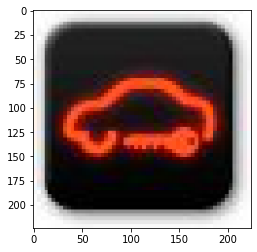

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen=tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test = datagen.flow_from_directory('/content/drive/MyDrive/Testi', class_mode='binary', batch_size=10,target_size=(224,224))
test_image, test_label = next(iter(test))
img=test_image[0]
plt.imshow(img)
img = (np.expand_dims(img,0))
prediction = model.predict(img)
result_ids = np.argmax(prediction[0],axis=-1)
result_labels = dataset_labels[result_ids]
a=int(result_labels)
print(a)
for i in classes:
  if a==i:
    print(classes[i])

In [31]:
type(model)

keras.engine.sequential.Sequential

In [32]:
import pickle


In [33]:
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)


INFO:tensorflow:Assets written to: ram://68d353c5-c277-4443-909f-5829c5c43550/assets


INFO:tensorflow:Assets written to: ram://68d353c5-c277-4443-909f-5829c5c43550/assets


In [34]:
with open('model_pkl' , 'rb') as f:
    lr = pickle.load(f)

In [35]:
type(lr)

keras.engine.sequential.Sequential

Found 1 images belonging to 1 classes.
23
wheelLock_hover


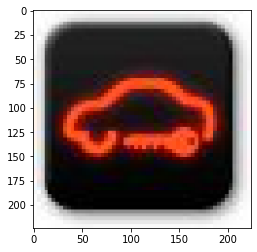

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen=tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test = datagen.flow_from_directory('/content/drive/MyDrive/Testi', class_mode='binary', batch_size=10,target_size=(224,224))
test_image, test_label = next(iter(test))
img=test_image[0]
plt.imshow(img)
img = (np.expand_dims(img,0))
prediction = lr.predict(img)
result_ids = np.argmax(prediction[0],axis=-1)
result_labels = dataset_labels[result_ids]
a=int(result_labels)
print(a)
for i in classes:
  if a==i:
    print(classes[i])